# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import astropy.units as u
import poppy
from simulator import SkyMap, GaiaTelescopeV0

/home/pietrof/miniforge3/lib/python3.12/site-packages/cupyx/jit/_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


## The simulator

The idea of the `SimulatorV0` is to simply create a map of close point-like sources, spanning different angles and separations, to convolve with a constructed (very simplified) _Gaia_ PSF (created with `Poppy`)

```python
from scipy.ndimage import zoom

def resample_sky_to_detector(sky_map, sky_pixscale, detector_shape, detector_pixscale):
    """
    Resample the sky map to match the detector's pixel scale and shape.
    """
    scale_factor = sky_pixscale / detector_pixscale
    zoom_factors = (detector_shape[0] / sky_map.shape[0], detector_shape[1] / sky_map.shape[1])
    resampled_sky = zoom(sky_map, zoom_factors, order=1)
    return resampled_sky

# Example usage:
sky_pixscale = 0.01  # arcsec/pixel (sky map)
detector_pixscale = 0.05  # arcsec/pixel (poppy)
detector_shape = (128, 128)
resampled_sky = resample_sky_to_detector(sky_map, sky_pixscale, detector_shape, detector_pixscale)

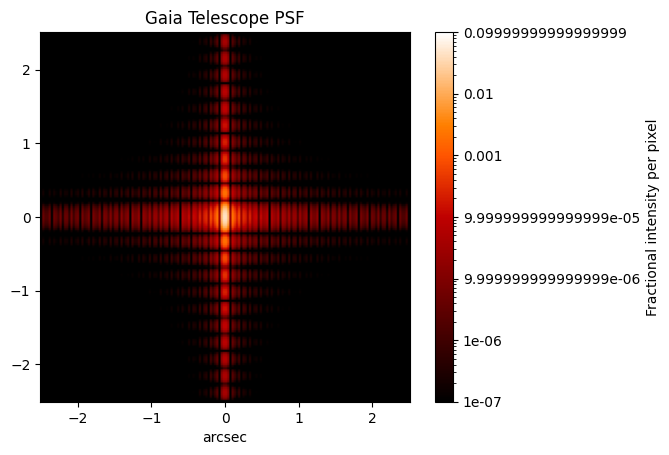

In [2]:
sm = SkyMap(map_noise=5)
gt = GaiaTelescopeV0()
gt.display_psf()
sssm = sm.create_single_star_sky_map(10, (128,128))

5
0
1 shift=0
2 shift=0
3 shift=0
4 shift=0


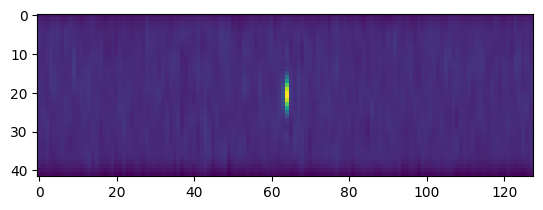

In [3]:
plt.imshow(gt.observeSkyMap(sssm))

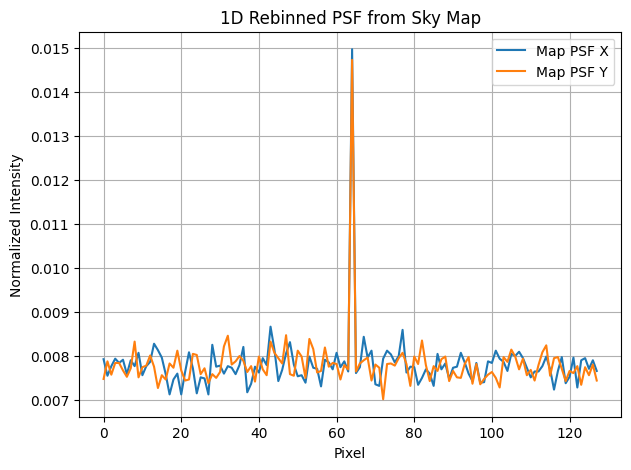

In [4]:
map_psf_x = np.sum(sssm, axis=0)  # or axis=1, depending on scan direction
map_psf_x = map_psf_x/np.sum(map_psf_x)  # normalize
map_psf_y = np.sum(sssm, axis=1)  # or axis=0, depending on scan direction
map_psf_y = map_psf_y/np.sum(map_psf_y)  # normalize
plt.figure(figsize=(7, 5))
plt.title('1D Rebinned PSF from Sky Map')
plt.plot(map_psf_x, label='Map PSF X')
plt.plot(map_psf_y, label='Map PSF Y')
plt.legend()
plt.xlabel('Pixel')
plt.ylabel('Normalized Intensity')
plt.grid()
plt.show()

In [5]:
import synphot as sp

In [6]:
star = sp.BlackBody1D(temperature=5778*u.K, name='Sun BB')

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
from scipy.ndimage import shift
from astropy.io import fits

class GaiaTDISimulator:
    """Physics-informed simulator for Gaia's TDI observations."""
    
    def __init__(self, pupil_diameter=1.45*u.m, 
                 apert_w=1.5*u.m,
                 apert_h=0.5*u.m,  # Approximate dimensions of Gaia's primary mirror
                 focal_length=35.0*u.m,  # Focal length of Gaia's telescope
                 pixel_scale=0.057*u.arcsec/u.pixel,  # 57 mas per pixel (along scan)
                 pixel_scale_y=0.177*u.arcsec/u.pixel, # 177 mas per pixel (across scan)
                 wavelength=650*u.nm,  # Approximate for Gaia G band
                 scan_rate=60*u.arcsec/u.s,  # Nominal scanning rate
                 n_steps=100):  # Number of time steps for simulation
        
        self.apert_w = apert_w
        self.apert_h = apert_h
        self.focal_length = focal_length
        self.pixel_scale = pixel_scale
        self.pixel_scale_y = pixel_scale_y
        self.wavelength = wavelength
        self.scan_rate = scan_rate
        self.n_steps = n_steps
        
        # Calculate the pixel shift rate based on scan rate
        self.pixel_shift_rate = (scan_rate / pixel_scale).decompose().value  # pixels/second
        
        # Set up optical system
        self.osys = self._create_optical_system()
    
    def _create_optical_system(self):
        """Create the Gaia optical system using Poppy."""
        # For simplicity, using a circular aperture with central obstruction
        # In reality, Gaia has rectangular primary mirrors
        osys = poppy.OpticalSystem(oversample=4)
        
        # Define the pupil - for more accuracy, you might want to define
        # a custom rectangular aperture matching Gaia's mirrors
        pupil = poppy.RectangleAperture(width=self.apert_w, height=self.apert_h)
        # Add central obstruction
        osys.add_pupil(pupil)
        
        # Add a detector with appropriate pixel scale (for oversampled PSF)
        osys.add_detector(pixelscale=self.pixel_scale.value/4, fov_pixels=128)
        
        return osys
    
    def generate_static_psf(self):
        """Generate a static, diffraction-limited PSF."""
        psf = self.osys.calc_psf(wavelength=self.wavelength)
        return psf[0].data
    
    def generate_tdi_psf(self, exposure_time=4.4*u.s):
        """
        Generate a PSF as observed in TDI mode.
        
        Parameters:
        -----------
        exposure_time : astropy.units.Quantity
            The effective exposure time for a star crossing the CCD.
            For Gaia, typical exposure time per CCD is ~4.4 seconds.
            
        Returns:
        --------
        tdi_psf : numpy.ndarray
            The simulated PSF as would be observed in TDI mode.
        """
        # Generate static oversampled PSF
        static_psf = self.generate_static_psf()
        
        # Calculate time step
        dt = (exposure_time / self.n_steps).to(u.s).value
        
        # Calculate pixel shift per time step
        dx_per_step = self.pixel_shift_rate * dt / 4  # Divide by 4 for oversampling
        
        # Initialize accumulated charge array
        accumulated_charge = np.zeros_like(static_psf)
        
        # Simulate TDI process
        for i in range(self.n_steps):
            # Current position of the star on the detector
            current_position = i * dx_per_step
            
            # Shift the PSF to current position
            shifted_psf = shift(static_psf, [0, current_position], mode='constant', cval=0)
            
            # Accumulate charge
            accumulated_charge += shifted_psf
            
            # Shift accumulated charge (simulating charge transfer)
            accumulated_charge = shift(accumulated_charge, [0, dx_per_step], mode='constant', cval=0)
        
        # Resample to detector pixel scale (accounting for rectangular pixels)
        # In a full implementation, you would need to bin differently in x and y
        # to account for Gaia's rectangular pixels
        
        return accumulated_charge
    
    def simulate_star_observation(self, magnitude=15, position=(64, 64), 
                                 fov_size=(1966, 4500), 
                                 readout_noise=10):
        """
        Simulate the observation of a star with the Gaia telescope in TDI mode.
        
        Parameters:
        -----------
        magnitude : float
            Magnitude of the star.
        position : tuple
            Position of the star in the field of view (pixels).
        fov_size : tuple
            Size of the field of view (pixels).
        readout_noise : float
            RMS of readout noise (electrons).
            
        Returns:
        --------
        observation : numpy.ndarray
            Simulated observation of the star.
        """
        # Generate TDI PSF
        tdi_psf = self.generate_tdi_psf()
        
        # Calculate flux based on magnitude
        flux = 10**(-0.4 * magnitude) * 1e6  # Arbitrary scaling
        
        # Create empty image matching CCD dimensions
        image = np.zeros(fov_size, dtype=np.float64)
        
        # Place PSF at the specified position
        y, x = position
        psf_size = tdi_psf.shape[0]
        half_psf = psf_size // 2
        
        # Ensure PSF fits within image bounds
        y_min = max(0, y - half_psf)
        y_max = min(fov_size[1], y + half_psf)
        x_min = max(0, x - half_psf)
        x_max = min(fov_size[0], x + half_psf)
        
        # Calculate corresponding PSF indices
        psf_y_min = max(0, half_psf - y)
        psf_y_max = min(psf_size, psf_size - (y + half_psf - fov_size[1]))
        psf_x_min = max(0, half_psf - x)
        psf_x_max = min(psf_size, psf_size - (x + half_psf - fov_size[0]))
        # Add scaled PSF to image
        image[y_min:y_max, x_min:x_max] += tdi_psf[psf_y_min:psf_y_max, psf_x_min:0] * flux
        
        # Add Poisson noise (photon noise)
        image = np.random.poisson(image)
        
        # Add Gaussian readout noise
        image = image + np.random.normal(0, readout_noise, image.shape)
        
        return image
    
    def visualize_psf_comparison(self):
        """Visualize comparison between static and TDI PSFs."""
        static_psf = self.generate_static_psf()
        tdi_psf = self.generate_tdi_psf()
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot static PSF
        im0 = axes[0].imshow(np.log10(static_psf + 1e-10), 
                            extent=[-static_psf.shape[1]/2*self.pixel_scale.value/4, 
                                    static_psf.shape[1]/2*self.pixel_scale.value/4,
                                    -static_psf.shape[0]/2*self.pixel_scale.value/4, 
                                    static_psf.shape[0]/2*self.pixel_scale.value/4])
        axes[0].set_title('Static PSF')
        axes[0].set_xlabel('arcsec')
        axes[0].set_ylabel('arcsec')
        plt.colorbar(im0, ax=axes[0], label='log10(intensity)')
        
        # Plot TDI PSF
        im1 = axes[1].imshow(np.log10(tdi_psf + 1e-10), 
                            extent=[-tdi_psf.shape[1]/2*self.pixel_scale.value/4, 
                                    tdi_psf.shape[1]/2*self.pixel_scale.value/4,
                                    -tdi_psf.shape[0]/2*self.pixel_scale.value/4, 
                                    tdi_psf.shape[0]/2*self.pixel_scale.value/4])
        axes[1].set_title('TDI PSF')
        axes[1].set_xlabel('arcsec')
        plt.colorbar(im1, ax=axes[1], label='log10(intensity)')
        
        # Plot profile comparison
        center_row = static_psf.shape[0] // 2
        axes[2].plot(static_psf[center_row, :], label='Static')
        axes[2].plot(tdi_psf[center_row, :], label='TDI')
        axes[2].set_yscale('log')
        axes[2].set_title('PSF Profile Comparison')
        axes[2].set_xlabel('Pixel')
        axes[2].set_ylabel('Intensity (log scale)')
        axes[2].legend()
        
        plt.tight_layout()
        return fig

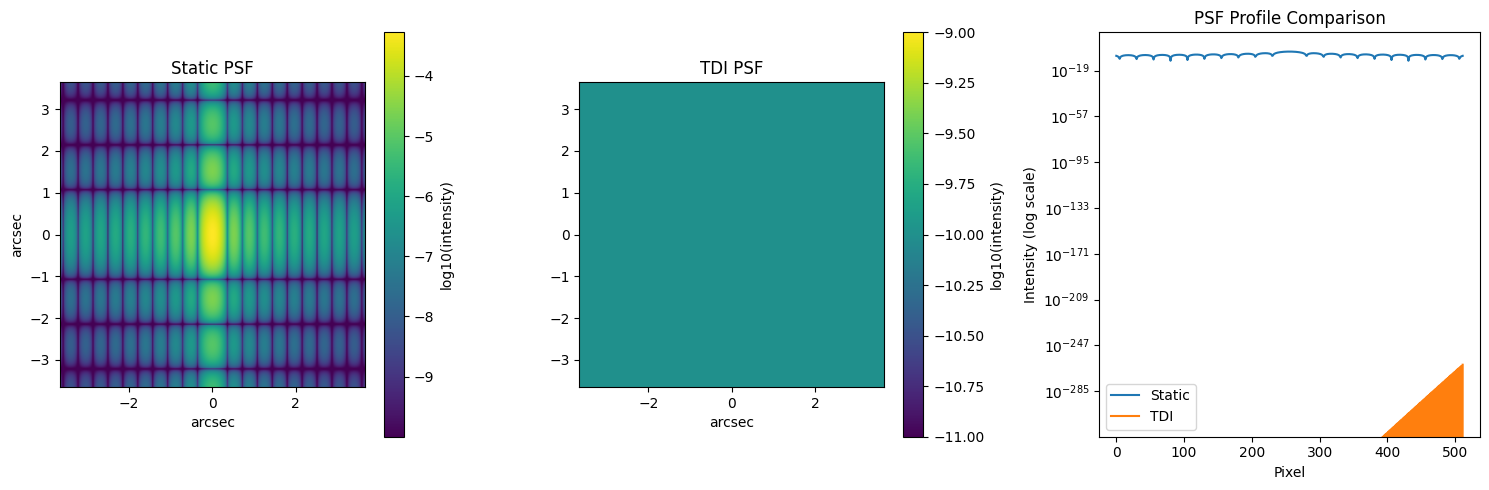

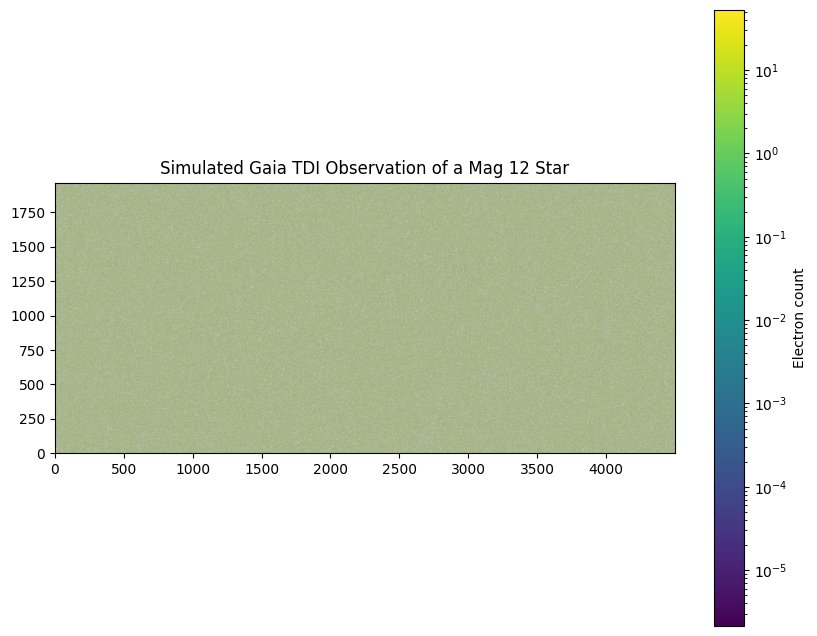

In [36]:
# Create the simulator
simulator = GaiaTDISimulator()

# Generate and compare static vs TDI PSFs
simulator.visualize_psf_comparison()

# Simulate observation of a magnitude 12 star
observation = simulator.simulate_star_observation(magnitude=12, 
                                                 position=(983, 2250),  # Center of the CCD
                                                 fov_size=(1966, 4500))

# Visualize the observation
plt.figure(figsize=(10, 8))
plt.imshow(observation, origin='lower', cmap='viridis', 
           norm=plt.matplotlib.colors.LogNorm())
plt.colorbar(label='Electron count')
plt.title('Simulated Gaia TDI Observation of a Mag 12 Star')
plt.savefig('gaia_star_observation.png', dpi=300)

In [40]:
import numpy as np
import synphot as sp
import poppy
import astropy.units as u
from astropy.io import fits

class GaiaStarSimulator:
    """Physics-informed stellar source simulator for Gaia observations."""
    
    def __init__(self, teff=5778*u.K, logg=4.44, metallicity=0.0, 
                 magnitude=15.0, band='G'):
        """
        Initialize a stellar source model for Gaia simulation.
        
        Parameters:
        -----------
        teff : astropy.units.Quantity
            Effective temperature of the star
        logg : float
            Surface gravity (log g)
        metallicity : float
            Metallicity [Fe/H]
        magnitude : float
            Apparent magnitude in specified band
        band : str
            Gaia band ('G', 'BP', or 'RP')
        """
        self.teff = teff
        self.logg = logg
        self.metallicity = metallicity
        self.magnitude = magnitude
        self.band = band
        
        # Generate stellar spectrum
        self.spectrum = self._create_stellar_spectrum()
        
        # Load Gaia bandpass
        self.bandpass = self._load_gaia_bandpass()
        
        # Calculate flux
        self.observation = sp.Observation(self.spectrum, self.bandpass)
        self.flux = self._calculate_flux()
    
    def _create_stellar_spectrum(self):
        """Create a stellar spectrum using Kurucz models."""
        # This is a simplified version - in reality you would select the 
        # appropriate model based on teff, logg, and metallicity
        # Alternatively, you can use SPISEA to generate a more physical model
        
        # For demonstration - using a blackbody approximation
        bb = sp.SourceSpectrum(sp.BlackBodyNorm1D, temperature=self.teff)
        
        # Normalize to desired magnitude
        return bb
    
    def _load_gaia_bandpass(self):
        """Load the appropriate Gaia bandpass."""
        # In practice, you would load the actual Gaia bandpass data
        # Here using a gaussian approximation for simplicity
        if self.band == 'G':
            center = 673 * u.nm
            width = 440 * u.nm
        elif self.band == 'BP':
            center = 532 * u.nm
            width = 253 * u.nm
        elif self.band == 'RP':
            center = 797 * u.nm
            width = 296 * u.nm
        else:
            raise ValueError(f"Unknown band: {self.band}")
            
        return sp.SpectralElement(sp.Box1D, x_0=center, width=width)
    
    def _calculate_flux(self):
        """Calculate the total flux based on magnitude."""
        # Convert magnitude to physical flux
        ref_flux = 3.631e-9 * u.erg / u.s / u.cm**2 / u.Hz  # Vega zero point
        flux = ref_flux * 10**(-0.4 * self.magnitude)
        
        # Normalize spectrum to this flux
        norm_spec = self.observation.normalize(flux, self.bandpass)
        
        return norm_spec.integrate()
    
    def generate_monochromatic_source(self, wavelength=550*u.nm, npixels=128, 
                                     oversample=4):
        """
        Generate a monochromatic source image.
        
        This is a simplified source model that can be used as input to 
        the optical propagation system.
        
        Parameters:
        -----------
        wavelength : astropy.units.Quantity
            Wavelength to generate the source at
        npixels : int
            Size of the source array
        oversample : int
            Oversampling factor
            
        Returns:
        --------
        source : numpy.ndarray
            Source image array
        """
        # For a point source, this is just a delta function
        # For extended sources, this would be more complex
        source = np.zeros((npixels*oversample, npixels*oversample))
        source[npixels*oversample//2, npixels*oversample//2] = 1.0
        
        # Scale by flux at this wavelength
        mono_flux = self.observation.sample(wavelength)
        source *= mono_flux.value
        
        return source
    
    def get_integrated_flux(self):
        """Get the total integrated flux across the bandpass."""
        return self.flux

In [41]:
s = GaiaStarSimulator()

In [54]:
s.observation.as_spectrum()